# Neural Network w/ backpropagation in Python from scratch

Lecture: https://www.youtube.com/watch?v=59Hbtz7XgjM
Post: https://cs231n.github.io/optimization-2/
Post: https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
Video: https://www.youtube.com/watch?v=4shguqlkTDM
Code Inspiration: https://github.com/yacineMahdid/artificial-intelligence-and-machine-learning/blob/master/deep-learning-from-scratch-python/multi_layer_perceptron.ipynb (different data, try out different activations - sigmoid, ReLu, tanh)
Code Inspiration 2: https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/

### Functional Implementation

In [146]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import random

In [2]:
train = [[2.7810836,2.550537003, 0],
           [1.465489372,2.362125076, 0],
           [3.396561688,4.400293529, 0],
           [1.38807019,1.850220317, 0],
           [3.06407232,3.005305973, 0],
           [7.627531214,2.759262235, 1],
           [5.332441248,2.088626775, 1],
           [6.922596716,1.77106367, 1],
           [8.675418651,-0.242068655, 1],
           [7.673756466,3.508563011, 1]]

In [3]:
# 1. Initialize network with weights

n_hidden = 1 # number of hidden layers
n_inputs = len(train[0][:-1]) # number of features
n_hidden_neurons = [1, 1] # number of neurons in hidden layer
n_outputs = 2 # number of possible outputs to be predicted

def init_network(n_inputs, n_hidden, n_hidden_neurons, n_outputs):

    network = []
    
    # number of parameters = 1 per input (features in original data) + bias = n_inputs + 1
    # number of neurons in layer = n_hidden_neurons[i]
    i = 0
    for n in range(n_hidden):
        if i == 0:
            hidden_layer = [{'params': [np.random.rand() for n in range(n_inputs + 1)]} for n in range(n_hidden_neurons[i])]
        else:
            hidden_layer = [{'params': [np.random.rand() for n in range(n_hidden_neurons[i-1] + 1)]} for n in range(n_hidden_neurons[i])]
        network.append(hidden_layer)
        i += 1
        
    # number of parameters = 1 per input (neurons in previous hidden layer) + bias = n_hidden + 1
    # number of neurons in layer = n_outputs
    output_layer = [{'params': [np.random.rand() for n in range(n_hidden_neurons[i-1] + 1)]} for n in range(n_outputs)]
    network.append(output_layer)
    
    return network

def print_layers(network):
    i = 0
    for layer in network:
        if i < n_hidden:
            print(f'HIDDEN LAYER {i+1}')
            print(layer)
            print(' ')
        if i == n_hidden:
            print('OUTPUT LAYER')
            print(layer)
        i += 1
        
network = init_network(n_inputs, n_hidden, n_hidden_neurons, n_outputs)

print_layers(network)

HIDDEN LAYER 1
[{'params': [0.017096093895541564, 0.3173433393457825, 0.06229131507782726]}]
 
OUTPUT LAYER
[{'params': [0.8183682294180846, 0.2854913578958649]}, {'params': [0.5438444788696442, 0.7981150417513115]}]


In [4]:
# Activation functions
def sigmoid(output):
    return 1.0 / (1.0 + np.exp(-output))

def ReLu(output):
    return max(0, output)

def tanh(output):
    return (np.exp(output)-np.exp(-output))/(np.exp(output)+np.exp(-output))

activation_functions = ('sigmoid', 'ReLu', 'tanh')

In [5]:
# 2. Forward propagate

# Calculates the output of a single neuron -> (weights * inputs) + bias
def calc_neuron_output(params, inputs):
    bias = params[-1]
    output = bias
    for i in range(len(params) - 1): # for every weight
        output += params[i] * inputs[i]
    return output

def forward_propagate(network, inputs):
    
    for layer in network:
        
        # this list will store the activated output of each neuron to be the input of the next layer
        # (in case the current layer is a hidden layer). Otherwise, this list will represent the outputs of the model
        next_inputs = []
        
        for neuron in layer:
            neuron_out = calc_neuron_output(neuron['params'], inputs) # linear output of neuron
            neuron['output_activated'] = sigmoid(neuron_out) # sigmoid activation of linear output
            next_inputs.append(neuron['output_activated'])
            
        inputs = next_inputs

    return inputs # outputs of output layer

forward_propagate(network, train[0][:-1])

[0.7048562110160425, 0.7661864825715318]

In [6]:
# Derivatives of activation functions
def d_sigmoid(s):
    return s*(1-s)

def d_ReLu(r):
    return 1 if r > 0 else 0

def d_tanh(t):
    return 1-t**2

In [7]:
print_layers(network)

HIDDEN LAYER 1
[{'params': [0.017096093895541564, 0.3173433393457825, 0.06229131507782726], 'output_activated': 0.7148857802693515}]
 
OUTPUT LAYER
[{'params': [0.8183682294180846, 0.2854913578958649], 'output_activated': 0.7048562110160425}, {'params': [0.5438444788696442, 0.7981150417513115], 'output_activated': 0.7661864825715318}]


In [8]:
# 3. Back propagate error

# delta (error) for neuron in output layer = (y_pred-y_expected) * d_actv
# delta (error) for neuron in hidden layers = sum(all connected weights from top layer * corresponding delta)

# i is the ith layer of the network we are iterating through
# expected_output are the expected outputs of the network (neurons in the output layer)
##([1,0] for 0 , [0,1] for 1) (answer corresponds to the index where 1 is)

def backpropagate(network, i, expected_output):
    
    # Base case -- backpropagation starts in output layer
    if i == n_hidden:

        for n in range(len(network[i])): # loop through each neuron in the layer i of the network (output layer)
            neuron = network[i][n] # current neuron
            error = neuron['output_activated'] - expected_output[n] # error for output in neuron n of output layer
            neuron['delta'] = error * d_sigmoid(neuron['output_activated'])
        return
    # End of base case

    errors = backpropagate(network, i + 1, expected_output)
    
    for n in range(len(network[i])): # loop through each neuron in the layer i of the network (hidden layer)
        neuron = network[i][n] # current neuron
        error = 0.0
        for top_neuron in network[i+1]: # for each neuron in layer above
            # (weights of top layer that the neuron output was multiplied by) * (corresponding delta)
            error += top_neuron['params'][n] * top_neuron['delta']
        neuron['delta'] = error * d_sigmoid(neuron['output_activated'])
        
    return
            
backpropagate(network, 0, [1,0])

In [9]:
print_layers(network)

HIDDEN LAYER 1
[{'params': [0.017096093895541564, 0.3173433393457825, 0.06229131507782726], 'output_activated': 0.7148857802693515, 'delta': 0.004973189296678377}]
 
OUTPUT LAYER
[{'params': [0.8183682294180846, 0.2854913578958649], 'output_activated': 0.7048562110160425, 'delta': -0.06139992316623163}, {'params': [0.5438444788696442, 0.7981150417513115], 'output_activated': 0.7661864825715318, 'delta': 0.13725829085095367}]


In [10]:
# 4. Train network

def update_weights(network, row, lr):
    for i in range(len(network)): # for every layer in the network
        inputs = row[:-1] # take training inputs
        if i != 0: # for all layers except the first
            inputs = [neuron['output_activated'] for neuron in network[i-1]] # inputs are the output of the previous layer
        for neuron in network[i]: # for every neuron in the layer
            for j in range(len(inputs)): # for every input to the layer (every weight in the neuron)
                neuron['params'][j] -= lr * neuron['delta'] * inputs[j] # weight update
            neuron['params'][-1] -= lr * neuron['delta'] # bias update

def train_network(network, training_data, lr, n_epochs):
    
    for n_epoch in range(n_epochs):
        sse = 0.0
        
        for row in training_data:
            output = forward_propagate(network, row)
            expected = [0 for i in range(len(output))] # initialize to an array of 0s of same size as outputs
            expected[row[-1]] = 1 # if actual output is 1, expected is [0,1], if 0 it is [1,0]
            sse += sum([(expected[i]-output[i])**2 for i in range(len(expected))])
            backpropagate(network, 0, expected)
            update_weights(network, row, lr)
        
        if n_epoch % 50 == 0:
            print('>epoch=%d, error=%.3f' % (n_epoch, sse)) 

In [11]:
def backprop(training_data, lr, n_epochs, n_inputs, n_hidden, n_hidden_neurons, n_outputs):
    model = init_network(n_inputs, n_hidden, n_hidden_neurons, n_outputs)
    train_network(model, training_data, lr, n_epochs)
    
    return model
    
lr = 0.2
training_data = train
n_epochs = 501

model = backprop(training_data, lr, n_epochs, n_inputs, n_hidden, n_hidden_neurons, n_outputs)

>epoch=0, error=5.397
>epoch=50, error=5.083
>epoch=100, error=2.326
>epoch=150, error=0.656
>epoch=200, error=0.340
>epoch=250, error=0.223
>epoch=300, error=0.164
>epoch=350, error=0.129
>epoch=400, error=0.106
>epoch=450, error=0.090
>epoch=500, error=0.078


In [12]:
#### 5. Predict
def predict(model, train):
    
    preds = [] # stores the predictions of all data points of the training data
    
    for row in training_data:
        label = row[-1]
        features = row[:-1]
        outputs = forward_propagate(model, features)
        pred = outputs.index(max(outputs))
        preds.append(pred)
    
    return preds

predict(model, train)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [147]:
# Load a csv file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

In [14]:
# 6. Predict on fraud detection dataset - https://www.kaggle.com/datasets/whenamancodes/fraud-detection?resource=download

ccard_data = load_csv('creditcard.csv')
ccard_data_mod = []
i = 0
for row in ccard_data: # take only first 2 features and output, convert from string to float/integer
    if i != 0:
        new_row = row[1:3]
        for j in range(len(new_row)):
            new_row[j] = float(new_row[j])
        new_row.append(int(row[30]))

        ccard_data_mod.append(new_row)
    i += 1

traincc = ccard_data_mod[:8000]
testcc = ccard_data_mod[8000:10000]

lr = 0.1
training_data = traincc
n_epochscc = 501

n_hiddencc = 1 # number of hidden layers
n_inputscc = len(traincc[0][:-1]) # number of features
n_hidden_neuronscc = [1,1] # number of neurons in hidden layer
n_outputscc = 2 # number of possible outputs to be predicted

modelcc = backprop(traincc, lr, n_epochscc, n_inputscc, n_hiddencc, n_hidden_neuronscc, n_outputscc)

>epoch=0, error=118.109
>epoch=50, error=48.906
>epoch=100, error=45.667
>epoch=150, error=27.902
>epoch=200, error=23.561
>epoch=250, error=22.193
>epoch=300, error=21.502
>epoch=350, error=21.101
>epoch=400, error=20.847
>epoch=450, error=20.677
>epoch=500, error=20.557


In [54]:
# Confusion Matrix
class ConfusionMatrix:
    
    def __init__(self, modelcm, data):
        self.model = modelcm
        self.data = data
        self.conf_matrix = None
        
        # METRICS
        self.accuracy = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.fprate = 0.0
        self.fnrate = 0.0
        
    def predict(self):
    
        preds = [] # stores the predictions of all data points of the training data

        for row in self.data:
            features = row[:-1]
            outputs = forward_propagate(self.model, features)
            pred = outputs.index(max(outputs))
            preds.append(pred)

        return preds
    
    def print_matrix(self):
        print(self.conf_matrix)
        print(' ')
        
    def print_metrics(self):
        # Accuracy (what fraction does it get right) = (# TP + # TN) / Total
        self.accuracy = (self.conf_matrix['TPs'] + self.conf_matrix['TNs']) / sum(self.conf_matrix.values())
        print('ACCURACY: ', round(self.accuracy, 3))
        print(' ')
        
        # Precision (when it says 1, how often is it right) = # TP / (# TP + # FP)
        self.precision = self.conf_matrix['TPs'] / (self.conf_matrix['TPs'] + self.conf_matrix['FPs'])
        print('PRECISION: ', round(self.precision, 3))
        print(' ')
        
        # Recall (what fraction of 1s does it get right) = # TP / (# TP + # FN)
        self.recall = self.conf_matrix['TPs'] / (self.conf_matrix['TPs'] + self.conf_matrix['FNs'])
        print('RECALL: ', round(self.recall, 3))
        print(' ')
        
        # False positive rate (what fraction of 0s are called 1s) = # FP / (# FP + # TN)
        self.fprate = self.conf_matrix['FPs'] / (self.conf_matrix['FPs'] + self.conf_matrix['TNs'])
        print('FALSE POSITIVE RATE: ', round(self.fprate, 3))
        print(' ')
        
        # False negative rate (what fraction of 1s are called 0s) = # FN / (# TP + # FN)
        self.fnrate = self.conf_matrix['FNs'] / (self.conf_matrix['TPs'] + self.conf_matrix['FNs'])
        print('FALSE NEGATIVE RATE: ', round(self.fnrate, 3))
    
    
    def plot_matrix(self):
        matrix_arr = [[self.conf_matrix['TNs'], self.conf_matrix['FPs']], [self.conf_matrix['FNs'], self.conf_matrix['TPs']]]
        plt.imshow(matrix_arr, cmap = 'coolwarm', alpha = 0.5)
        plt.xticks(np.arange(0, 2), ['0', '1'])
        plt.yticks(np.arange(0, 2), ['0', '1'])
        
        plt.text(-0.1, 0, matrix_arr[0][0], fontsize = 14) # TNs
        plt.text(0.95, 0, matrix_arr[0][1], fontsize = 14) # FPs
        plt.text(-0.1, 1, matrix_arr[1][0], fontsize = 14) # FNs
        plt.text(0.95, 1, matrix_arr[1][1], fontsize = 14) # TPs

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        
        
    def fit(self):
        self.conf_matrix = {'TPs': 0, 'TNs': 0, 'FPs': 0, 'FNs': 0}
        
        preds = self.predict()
        
        for i in range(len(preds)):
            label = self.data[i][-1]
            pred = preds[i]
            if label == 1 and pred == 1: # truly predicted positive
                self.conf_matrix['TPs'] += 1
            elif label == 0 and pred == 1: # falsely predicted positive
                self.conf_matrix['FPs'] += 1
            elif label == 1 and pred == 0: # falsely predicted negative
                self.conf_matrix['FNs'] += 1
            elif label == 0 and pred == 0: # truly predicted negative
                self.conf_matrix['TNs'] += 1
    

ACCURACY:  0.996
 
PRECISION:  0.625
 
RECALL:  0.769
 
FALSE POSITIVE RATE:  0.003
 
FALSE NEGATIVE RATE:  0.231


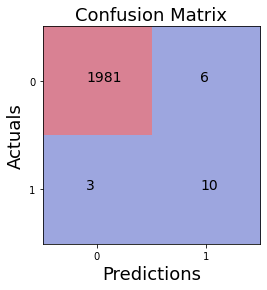

In [55]:
cc_cm = ConfusionMatrix(modelcc, testcc)
cc_cm.fit()
cc_cm.print_metrics()
cc_cm.plot_matrix()

In [114]:
# 7. Predict on titanic dataset - https://www.kaggle.com/competitions/titanic/data
titanic_train = load_csv('titanic_train.csv')

def modify_titanic(titanic_data, is_train = True):
    # take max and min of variables to be normalized
    age_min = 100
    age_max = 0
    sibsp_min = 100
    sibsp_max = 0
    parch_min = 100
    parch_max = 0
    fare_min = 100.0
    fare_max = 0.0
    
    # Test set indexes
    gender_ind = 3
    age_ind = 4
    sibsp_ind = 5
    parch_ind = 6
    fare_ind = 8
    
    # Adjust for train set (which includes 'Survived' label, hence the += 1)
    if is_train:
        gender_ind += 1
        age_ind += 1
        sibsp_ind += 1
        parch_ind += 1
        fare_ind += 1

    j = 0
    for row in titanic_data:
        if j != 0:
            age = int(row[age_ind]) if row[age_ind].isdigit() else age_min
            if age < age_min:
                age_min = age
            if age > age_max:
                age_max = age

            sibsp = int(row[sibsp_ind]) if row[sibsp_ind].isdigit() else sibsp_min
            if sibsp < sibsp_min:
                sibsp_min = sibsp
            if sibsp > sibsp_max:
                sibsp_max = sibsp

            parch = int(row[parch_ind]) if row[parch_ind].isdigit() else parch_min
            if parch < parch_min:
                parch_min = parch
            if parch > parch_max:
                parch_max = parch

            fare = float(row[fare_ind]) if row[fare_ind].isdigit() else fare_min
            if fare < fare_min:
                fare_min = fare
            if fare > fare_max:
                fare_max = fare
        j += 1
    
    titanic_mod = []
    invalids = [0] # indexes of invalid rows

    for i in range(len(titanic_data)): # take only first 2 features and output, convert from string to float/integer

        if i != 0:

            row = titanic_data[i]
            new_row = []

            gender = 1 if row[gender_ind] == 'male' else 0 # ind = 3 (test), 4 (train)
            new_row.append(gender)

            # scale 'Age' variable (row[5]) to [0,1] range and append to new_row
            if row[age_ind].isdigit(): # ind = 4 (test), 5 (train)
                age = int(row[age_ind])
                age_scaled = (age - age_min) / (age_max - age_min)
                new_row.append(age_scaled)

            # scale 'SibSp' variable (row[6]) and append to new_row
            if row[sibsp_ind].isdigit(): # ind = 5 (test), 6 (train)
                sibsp = int(row[sibsp_ind])
                sibsp_scaled = (sibsp - sibsp_min) / (sibsp_max - sibsp_min)
                new_row.append(sibsp_scaled)

            # scale 'Parch' variable (row[7]) and append to new_row
            if row[parch_ind].isdigit(): # ind = 6 (test), 7 (train)
                parch = int(row[parch_ind])
                parch_scaled = (parch - parch_min) / (parch_max - parch_min)
                new_row.append(parch_scaled)

            # scale 'Fare' variable (row[9]) and append to new_row
            if row[fare_ind].replace('.','',1).isdigit(): # ind = 8 (test), 9 (train)
                fare = float(row[fare_ind])
                fare_scaled = (fare - fare_min) / (fare_max - fare_min)
                new_row.append(fare_scaled)

            # append label ('Survived') (row[1]) to new_row
            if is_train:
                new_row.append(int(row[1]))

            if row[age_ind].isdigit() and row[sibsp_ind].isdigit() and row[parch_ind].isdigit() and row[fare_ind].replace('.','',1).isdigit():
                titanic_mod.append(new_row)
            else:
                invalids.append(i)
                
    return (titanic_mod, invalids)

titanic_train_mod = modify_titanic(titanic_train)[0]

In [63]:
lr = 0.2
training_data = titanic_train_mod
n_epochs_titanic = 501

n_hidden_titanic = 1 # number of hidden layers
n_inputs_titanic = len(titanic_train_mod[0][:-1]) # number of features
n_hidden_neurons_titanic = [5,1] # number of neurons in hidden layer
n_outputs_titanic = 2 # number of possible outputs to be predicted

model_titanic = backprop(titanic_train_mod, lr, n_epochs_titanic, n_inputs_titanic, n_hidden_titanic, n_hidden_neurons_titanic, n_outputs_titanic)

>epoch=0, error=363.822
>epoch=50, error=216.604
>epoch=100, error=210.771
>epoch=150, error=204.431
>epoch=200, error=200.632
>epoch=250, error=198.981
>epoch=300, error=197.669
>epoch=350, error=196.519
>epoch=400, error=195.472
>epoch=450, error=194.395
>epoch=500, error=193.192


ACCURACY:  0.813
 
PRECISION:  0.795
 
RECALL:  0.73
 
FALSE POSITIVE RATE:  0.13
 
FALSE NEGATIVE RATE:  0.27


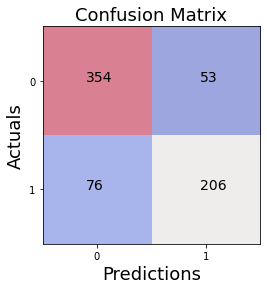

In [64]:
conf_matrix_titanic = ConfusionMatrix(model_titanic, titanic_train_mod)
conf_matrix_titanic.fit()
conf_matrix_titanic.print_metrics()
conf_matrix_titanic.plot_matrix()

In [164]:
# Kaggle submission - .csv file with columns 'PassengerId', 'Survived'
titanic_test = load_csv('titanic_test.csv')
titanic_test_mod, test_invalids = modify_titanic(titanic_test, is_train = False)

test_invalids

[0,
 1,
 11,
 23,
 28,
 30,
 34,
 36,
 37,
 40,
 42,
 48,
 55,
 59,
 66,
 74,
 76,
 77,
 84,
 85,
 86,
 89,
 92,
 94,
 103,
 108,
 109,
 110,
 112,
 114,
 117,
 122,
 125,
 128,
 133,
 134,
 137,
 147,
 149,
 152,
 153,
 161,
 164,
 169,
 171,
 174,
 184,
 189,
 192,
 193,
 200,
 201,
 202,
 206,
 212,
 217,
 220,
 226,
 228,
 229,
 234,
 244,
 245,
 250,
 251,
 255,
 256,
 257,
 261,
 266,
 267,
 268,
 269,
 272,
 274,
 275,
 282,
 283,
 287,
 289,
 290,
 291,
 293,
 298,
 302,
 305,
 308,
 313,
 333,
 340,
 343,
 345,
 355,
 358,
 359,
 361,
 366,
 367,
 381,
 383,
 385,
 409,
 411,
 414,
 416,
 417,
 418]

In [166]:
def predict_submission(model, data, data_mod, invalids):
    
    submission = []
    mod_index = 0

    for i in range(len(data)):
        if i != 0:
            if i in invalids:
                pred = random.choice([0,1])
            else:
                features = data_mod[mod_index]
                outputs = forward_propagate(model, features)
                pred = outputs.index(max(outputs))
                mod_index += 1
            submission.append([i+891, pred])
        
    return submission

# if index of row in titanic_test in invalids, predict randomly 0 or 1
titanic_submission = predict_submission(model_titanic, titanic_test, titanic_test_mod, test_invalids)

In [167]:
titanic_submission

[[892, 1],
 [893, 0],
 [894, 0],
 [895, 0],
 [896, 0],
 [897, 0],
 [898, 1],
 [899, 0],
 [900, 1],
 [901, 0],
 [902, 1],
 [903, 0],
 [904, 1],
 [905, 0],
 [906, 1],
 [907, 1],
 [908, 0],
 [909, 0],
 [910, 0],
 [911, 1],
 [912, 0],
 [913, 0],
 [914, 0],
 [915, 1],
 [916, 1],
 [917, 0],
 [918, 1],
 [919, 0],
 [920, 0],
 [921, 1],
 [922, 0],
 [923, 0],
 [924, 1],
 [925, 1],
 [926, 1],
 [927, 1],
 [928, 1],
 [929, 1],
 [930, 0],
 [931, 1],
 [932, 0],
 [933, 1],
 [934, 0],
 [935, 1],
 [936, 1],
 [937, 0],
 [938, 0],
 [939, 0],
 [940, 1],
 [941, 1],
 [942, 1],
 [943, 0],
 [944, 0],
 [945, 1],
 [946, 1],
 [947, 0],
 [948, 0],
 [949, 0],
 [950, 0],
 [951, 1],
 [952, 0],
 [953, 0],
 [954, 0],
 [955, 1],
 [956, 0],
 [957, 0],
 [958, 1],
 [959, 0],
 [960, 0],
 [961, 1],
 [962, 1],
 [963, 0],
 [964, 1],
 [965, 0],
 [966, 1],
 [967, 1],
 [968, 1],
 [969, 0],
 [970, 0],
 [971, 1],
 [972, 0],
 [973, 0],
 [974, 0],
 [975, 0],
 [976, 1],
 [977, 0],
 [978, 1],
 [979, 1],
 [980, 0],
 [981, 0],
 [982, 1],

In [168]:
# Kaggle submission - .csv file with columns 'PassengerId', 'Survived'
myFile = open('titanic_submission1.csv', 'w')
writer = csv.writer(myFile)
writer.writerow(['PassengerId', 'Survived'])
for data_list in titanic_submission:
    writer.writerow(data_list)
myFile.close()
myFile = open('titanic_submission1.csv', 'r')
print("The content of the csv file is:")
print(myFile.read())
myFile.close()

The content of the csv file is:
PassengerId,Survived
892,1
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1
901,0
902,1
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,0
911,1
912,0
913,0
914,0
915,1
916,1
917,0
918,1
919,0
920,0
921,1
922,0
923,0
924,1
925,1
926,1
927,1
928,1
929,1
930,0
931,1
932,0
933,1
934,0
935,1
936,1
937,0
938,0
939,0
940,1
941,1
942,1
943,0
944,0
945,1
946,1
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,0
957,0
958,1
959,0
960,0
961,1
962,1
963,0
964,1
965,0
966,1
967,1
968,1
969,0
970,0
971,1
972,0
973,0
974,0
975,0
976,1
977,0
978,1
979,1
980,0
981,0
982,1
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,1
991,0
992,1
993,0
994,0
995,0
996,0
997,0
998,0
999,1
1000,1
1001,0
1002,0
1003,1
1004,1
1005,1
1006,1
1007,0
1008,1
1009,1
1010,1
1011,1
1012,1
1013,1
1014,1
1015,0
1016,0
1017,1
1018,0
1019,0
1020,0
1021,0
1022,0
1023,0
1024,1
1025,0
1026,0
1027,0
1028,0
1029,0
1030,1
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,1
1039,0
1040,1
1041,0
1042,

In [169]:
titanic_submission_test = load_csv('titanic_submission1.csv')

In [170]:
titanic_submission_test

[['PassengerId', 'Survived'],
 ['892', '1'],
 ['893', '0'],
 ['894', '0'],
 ['895', '0'],
 ['896', '0'],
 ['897', '0'],
 ['898', '1'],
 ['899', '0'],
 ['900', '1'],
 ['901', '0'],
 ['902', '1'],
 ['903', '0'],
 ['904', '1'],
 ['905', '0'],
 ['906', '1'],
 ['907', '1'],
 ['908', '0'],
 ['909', '0'],
 ['910', '0'],
 ['911', '1'],
 ['912', '0'],
 ['913', '0'],
 ['914', '0'],
 ['915', '1'],
 ['916', '1'],
 ['917', '0'],
 ['918', '1'],
 ['919', '0'],
 ['920', '0'],
 ['921', '1'],
 ['922', '0'],
 ['923', '0'],
 ['924', '1'],
 ['925', '1'],
 ['926', '1'],
 ['927', '1'],
 ['928', '1'],
 ['929', '1'],
 ['930', '0'],
 ['931', '1'],
 ['932', '0'],
 ['933', '1'],
 ['934', '0'],
 ['935', '1'],
 ['936', '1'],
 ['937', '0'],
 ['938', '0'],
 ['939', '0'],
 ['940', '1'],
 ['941', '1'],
 ['942', '1'],
 ['943', '0'],
 ['944', '0'],
 ['945', '1'],
 ['946', '1'],
 ['947', '0'],
 ['948', '0'],
 ['949', '0'],
 ['950', '0'],
 ['951', '1'],
 ['952', '0'],
 ['953', '0'],
 ['954', '0'],
 ['955', '1'],
 ['956', '